In [16]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
from setfit import SetFitModel
from datasets import Dataset
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from transformers import Trainer
import warnings
warnings.filterwarnings("ignore")
import joblib

# Load the preprocessed dataset
df = pd.read_csv('../data/processed.csv')

# Encode the labels
label_encoder = LabelEncoder()
df['label_encoded'] = label_encoder.fit_transform(df['label'])
label_mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))

# Features and labels
X = df['text']
y = df['label_encoded']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42, stratify=y)

# Create training and test DataFrames
train_df = pd.DataFrame({'text': X_train, 'label': y_train})
test_df = pd.DataFrame({'text': X_test, 'label': y_test})

# Convert pandas DataFrames to Hugging Face Datasets
train_dataset = Dataset.from_pandas(train_df)
test_dataset = Dataset.from_pandas(test_df)

# Load a pre-trained multilingual model suitable for French
model = SetFitModel.from_pretrained('dangvantuan/sentence-camembert-base')

from setfit import TrainingArguments, Trainer

args = TrainingArguments(
    batch_size=32,
    num_iterations=20,
    num_epochs=10
)

trainer = Trainer(
    model=model,
    args=args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
)

trainer.train()

model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.


Map:   0%|          | 0/45 [00:00<?, ? examples/s]

***** Running training *****
  Num unique pairs = 1800
  Batch size = 32
  Num epochs = 10


  0%|          | 0/570 [00:00<?, ?it/s]

{'embedding_loss': 0.3392, 'grad_norm': 2.3385584354400635, 'learning_rate': 3.5087719298245616e-07, 'epoch': 0.02}
{'embedding_loss': 0.1845, 'grad_norm': 0.5921798348426819, 'learning_rate': 1.754385964912281e-05, 'epoch': 0.88}
{'embedding_loss': 0.0223, 'grad_norm': 0.25448015332221985, 'learning_rate': 1.8323586744639376e-05, 'epoch': 1.75}
{'embedding_loss': 0.005, 'grad_norm': 0.15400542318820953, 'learning_rate': 1.6374269005847955e-05, 'epoch': 2.63}
{'embedding_loss': 0.0025, 'grad_norm': 0.11993171274662018, 'learning_rate': 1.4424951267056531e-05, 'epoch': 3.51}
{'embedding_loss': 0.0018, 'grad_norm': 0.0512549914419651, 'learning_rate': 1.2475633528265108e-05, 'epoch': 4.39}
{'embedding_loss': 0.0015, 'grad_norm': 0.07109934091567993, 'learning_rate': 1.0526315789473684e-05, 'epoch': 5.26}
{'embedding_loss': 0.0012, 'grad_norm': 0.047152627259492874, 'learning_rate': 8.576998050682261e-06, 'epoch': 6.14}
{'embedding_loss': 0.0014, 'grad_norm': 0.05484593287110329, 'learnin

Computing widget examples:   0%|          | 0/1 [00:00<?, ?example/s]

{'embedding_loss': 0.0009, 'grad_norm': 0.0510295033454895, 'learning_rate': 7.797270955165692e-07, 'epoch': 9.65}
{'train_runtime': 182.7338, 'train_samples_per_second': 98.504, 'train_steps_per_second': 3.119, 'train_loss': 0.019871144844709258, 'epoch': 10.0}


In [17]:
# Evaluate the model on the test set
metrics = trainer.evaluate()
print(f"Accuracy: {metrics['accuracy']:.4f}")

***** Running evaluation *****


Accuracy: 0.9000


In [18]:
history = pd.DataFrame(trainer.st_trainer.state.log_history)
history.head()

,embedding_loss,grad_norm,learning_rate,epoch,step,train_runtime,train_samples_per_second,train_steps_per_second,total_flos,train_loss
0,0.3392,2.338558,3.508772e-07,0.017544,1,NaN,NaN,NaN,NaN,NaN
1,0.1845,0.592180,1.754386e-05,0.877193,50,NaN,NaN,NaN,NaN,NaN
2,0.0223,0.254480,1.832359e-05,1.754386,100,NaN,NaN,NaN,NaN,NaN
3,0.0050,0.154005,1.637427e-05,2.631579,150,NaN,NaN,NaN,NaN,NaN
4,0.0025,0.119932,1.442495e-05,3.508772,200,NaN,NaN,NaN,NaN,NaN


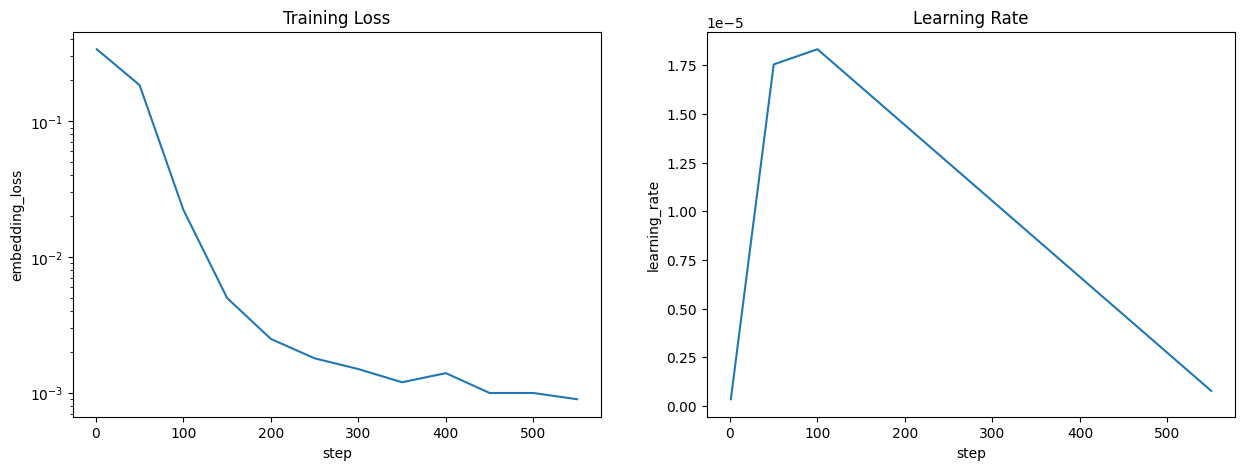

In [19]:
# Plot loss and learning rate by step
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
sns.lineplot(data=history, x='step', y='embedding_loss', ax=ax[0])
ax[0].set_yscale('log')
ax[0].set_title('Training Loss')
sns.lineplot(data=history, x='step', y='learning_rate', ax=ax[1])
ax[1].set_title('Learning Rate')

plt.show()

In [20]:
model.save_pretrained('../models/local_models/camembert_preprocessed')

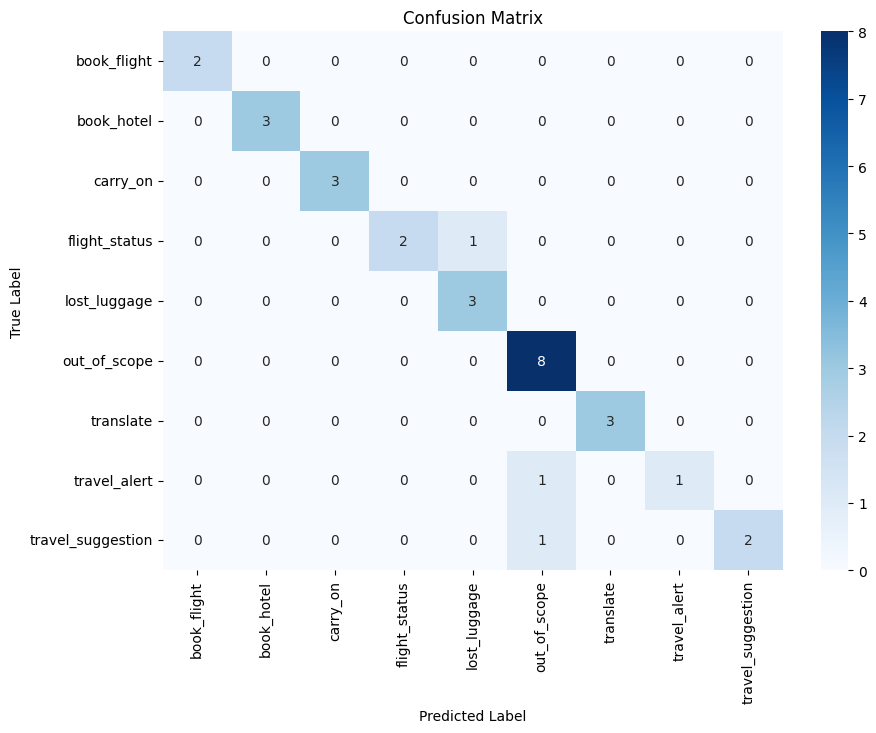

In [21]:
# Display confusion matrix and classification report
y_pred = model.predict(test_dataset['text'])

y_true = test_dataset['label']

# Plot the confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred, labels=list(label_mapping.values()))
conf_matrix_df = pd.DataFrame(conf_matrix, columns=label_mapping.keys(), index=label_mapping.keys())

plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix_df, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

In [22]:
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         2
           1       1.00      1.00      1.00         3
           2       1.00      1.00      1.00         3
           3       1.00      0.67      0.80         3
           4       0.75      1.00      0.86         3
           5       0.80      1.00      0.89         8
           6       1.00      1.00      1.00         3
           7       1.00      0.50      0.67         2
           8       1.00      0.67      0.80         3

    accuracy                           0.90        30
   macro avg       0.95      0.87      0.89        30
weighted avg       0.92      0.90      0.89        30



In [23]:
# Check time for a single prediction
import time

start_time = time.time()
model.predict(test_dataset['text'][0])
end_time = time.time()

print(f"Time for a single prediction: {end_time - start_time:.4f} seconds")

Time for a single prediction: 0.2143 seconds


In [24]:
joblib.dump(label_encoder, "../utils/label_encoder.joblib")

['../utils/label_encoder.joblib']